#  Frozen Lake using Dynamic Programming

In [25]:
import numpy as np 
import random
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.max_open_warning': 0})

import sys
from contextlib import closing

import numpy as np
from six import StringIO, b

from gym import utils
from gym.envs.toy_text import discrete

In [26]:
LEFT = 0
DOWN = 1
RIGHT = 2
UP = 3

MAPS = {
    "4x4": [
        "SFFF",
        "FHFH",
        "FFFH",
        "HFFG"
    ],
    "8x8": [
        "SFFFFFFF",
        "FFFFFFFF",
        "FFFHFFFF",
        "FFFFFHFF",
        "FFFHFFFF",
        "FHHFFFHF",
        "FHFFHFHF",
        "FFFHFFFG"
    ],
}


class FrozenLakeEnv(discrete.DiscreteEnv):
    """
    Winter is here. You and your friends were tossing around a frisbee at the park
    when you made a wild throw that left the frisbee out in the middle of the lake.
    The water is mostly frozen, but there are a few holes where the ice has melted.
    If you step into one of those holes, you'll fall into the freezing water.
    At this time, there's an international frisbee shortage, so it's absolutely imperative that
    you navigate across the lake and retrieve the disc.
    However, the ice is slippery, so you won't always move in the direction you intend.
    The surface is described using a grid like the following
        SFFF
        FHFH
        FFFH
        HFFG
    S : starting point, safe
    F : frozen surface, safe
    H : hole, fall to your doom
    G : goal, where the frisbee is located
    The episode ends when you reach the goal or fall in a hole.
    You receive a reward of 1 if you reach the goal, and zero otherwise.
    """

    metadata = {'render.modes': ['human', 'ansi']}

    def __init__(self, desc=None, map_name="4x4",is_slippery=True):
        if desc is None and map_name is None:
            desc = generate_random_map()
        elif desc is None:
            desc = MAPS[map_name]
        self.desc = desc = np.asarray(desc,dtype='c')
        self.nrow, self.ncol = nrow, ncol = desc.shape
        self.reward_range = (0, 1)

        nA = 4
        nS = nrow * ncol

        isd = np.array(desc == b'S').astype('float64').ravel()
        isd /= isd.sum()

        P = {s : {a : [] for a in range(nA)} for s in range(nS)}

        def to_s(row, col):
            return row*ncol + col

        def inc(row, col, a):
            if a==0: # left
                col = max(col-1,0)
            elif a==1: # down
                row = min(row+1,nrow-1)
            elif a==2: # right
                col = min(col+1,ncol-1)
            elif a==3: # up
                row = max(row-1,0)
            return (row, col)

        for row in range(nrow):
            for col in range(ncol):
                s = to_s(row, col)
                for a in range(4):
                    li = P[s][a]
                    letter = desc[row, col]
                    if letter in b'GH':
                        li.append((1.0, s, 0, True))
                    else:
                        if is_slippery:
                            for b in [(a-1)%4, a, (a+1)%4]:
                                newrow, newcol = inc(row, col, b)
                                newstate = to_s(newrow, newcol)
                                newletter = desc[newrow, newcol]
                                done = bytes(newletter) in b'GH'
                                rew = float(newletter == b'G')
                                li.append((1.0/3.0, newstate, rew, done))
                        else:
                            newrow, newcol = inc(row, col, a)
                            newstate = to_s(newrow, newcol)
                            newletter = desc[newrow, newcol]
                            done = bytes(newletter) in b'GH'
                            rew = float(newletter == b'G')
                            li.append((1.0, newstate, rew, done))

        # New change because environment only allows step without
        # specific state for learning environment!
        self.P = P

        super(FrozenLakeEnv, self).__init__(nS, nA, P, isd)

    def render(self, mode='human',close = False):
        if close:
            return
        outfile = StringIO() if mode == 'ansi' else sys.stdout

        row, col = self.s // self.ncol, self.s % self.ncol
        desc = self.desc.tolist()
        desc = [[c.decode('utf-8') for c in line] for line in desc]
        desc[row][col] = utils.colorize(desc[row][col], "red", highlight=True)
        if self.lastaction is not None:
            outfile.write("  ({})\n".format(["Left","Down","Right","Up"][self.lastaction]))
        else:
            outfile.write("\n")
        outfile.write("\n".join(''.join(line) for line in desc)+"\n")

        if mode != 'human':
            with closing(outfile):
                return outfile.getvalue() 

# Value Iteration Agent

In [27]:
class DP_Agent:
    
    def __init__(self,discount_factor):
        self.g = discount_factor
        self.MDP = FrozenLakeEnv()
        self.MDP.seed(0)
        self.terminals = [5,7,11,12,15]
        
        self.V = np.zeros(shape=(16),dtype = float)
        
    #Dynamic Programming
    
    def one_step_lookahead(self,state,V):
        
        A = np.zeros(self.MDP.nA)
        for a in range(self.MDP.nA):
            for prob,next_state,reward,done in self.MDP.P[state][a]:
                A[a] += prob * (reward + self.g * self.V[next_state])
        return A
    
    def update_DP(self):
        
        policy = np.zeros([self.MDP.nS])
        #Update each state..
        for s in range(self.MDP.nS):
            
            # Do a one_step_lookahead to find the best action
            A = self.one_step_lookahead(s,self.V)
            best_action_value = np.max(A)
            best_action = np.argmax(A)
            
            #Update the value function
            self.V[s] =  best_action_value
            policy[s] = best_action
        
        return policy, self.V

# Base Loop

In [28]:
agentDP = DP_Agent(discount_factor = 0.95)

In [31]:
Vs = [np.zeros(agentDP.MDP.nS)]
pis = []

for iterations in range(20):
    
    policy, V = agentDP.update_DP()
    Vs.append(V.copy())
    pis.append(policy)

# Visualization

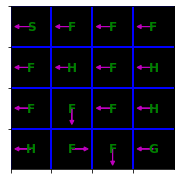

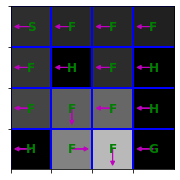

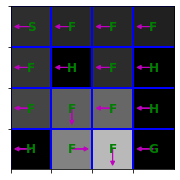

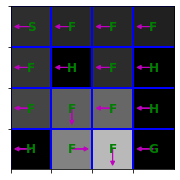

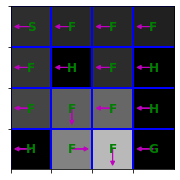

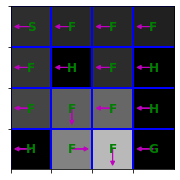

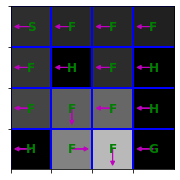

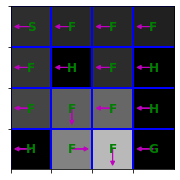

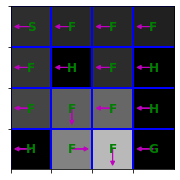

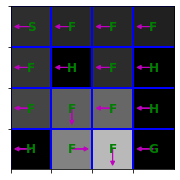

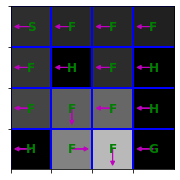

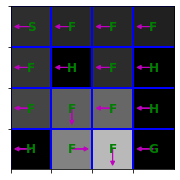

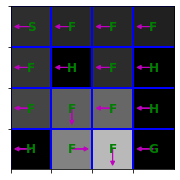

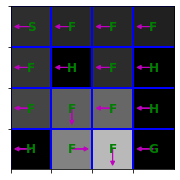

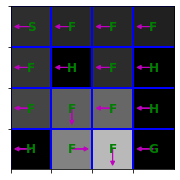

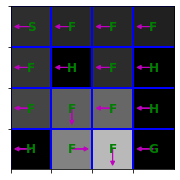

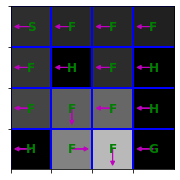

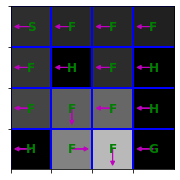

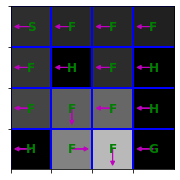

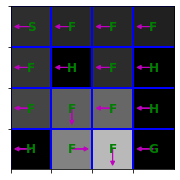

In [32]:
for(V,pi) in zip(Vs,pis):
    plt.figure(figsize=(3,3))
    plt.imshow(V.reshape(4,4), cmap = 'gray', interpolation = 'none', clim=(0,1))
    ax = plt.gca()
    ax.set_xticks(np.arange(4)-.5)
    ax.set_yticks(np.arange(4)-.5)
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    Y , X = np.mgrid[0:4, 0:4]
    a2uv = {0: (-1,0), 1:(0, -1), 2:(1,0), 3:(-1,0)}
    Pi = pi.reshape(4,4)
    for y in range(4):
        for x in range(4):
            a= Pi[y,x]
            u,v = a2uv[a]
            plt.arrow(x,y, u*.3, -v*.3, color = 'm' , head_width =0.1, head_length = 0.1)
            plt.text(x,y, str(agentDP.MDP.unwrapped.desc[y,x].item().decode()),color = 'g', size=12, verticalalignment='center',
                    horizontalalignment = 'center', fontweight = 'bold')
    
    plt.grid(color='b', lw=2 , ls='-')

#plt.figure()
#plt.plot(Vs)
#plt.title("Values of different states");

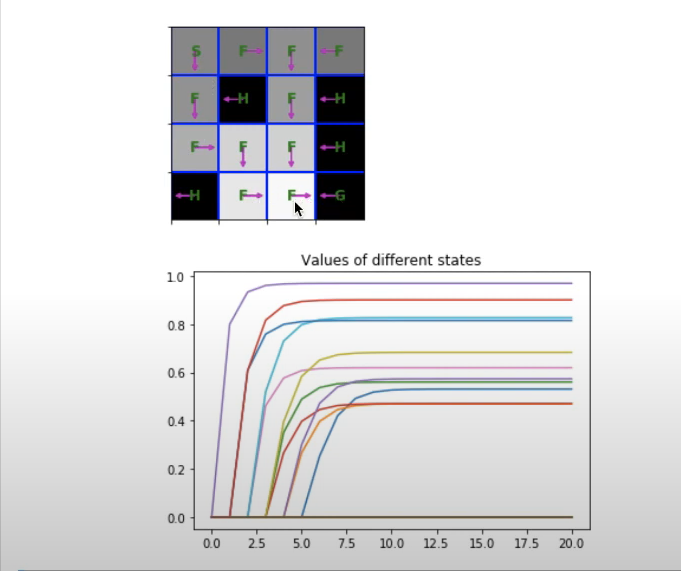